<a href="https://colab.research.google.com/github/mchivuku/CS659-Assignment1/blob/master/Variational_EM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 - Variational EM

In [0]:
import numpy as np
import numpy as np
import math

import os
import scipy
from scipy.stats import multivariate_normal as mvn, multivariate_normal
import logging
import matplotlib.pyplot as plt
from scipy import sparse


## Connect Google drive
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

%matplotlib inline

plt.style.use('fivethirtyeight')

plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 12

plt.rcParams['figure.figsize'] = 10, 6


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
## cd into folder - 
## content/drive/My Drive/Deep Learning - E533/Homework - 1
%cd /content/drive/My\ Drive/CSCI-B659/Assignment\ 2/



/content/drive/My Drive/CSCI-B659/Assignment 2


##Utility Function - Helpers

In [0]:
parameters = {
    "split_percent":0.5
}


"""
SET logger to enable logging to the file
"""
def set_logger(log_path):
    ## define logger
    logger = logging.getLogger()

    ## Log everything
    logger.setLevel(logging.INFO)

    ## If no handlers have been defined
    if not logger.handlers:
        # define file handler
        file_handler = logging.FileHandler(log_path)
        file_handler.setFormatter ( logging.Formatter ( '%(asctime)s:%(message)s' ) )

        logger.addHandler(file_handler)

    ## define console handler
    stream_handler= logging.StreamHandler()
    stream_handler.setFormatter(logging.Formatter( '%(asctime)s:%(message)s'))
    logger.addHandler(stream_handler)


"""
Read data from the text file
"""
def read_data(file):
    data = np.loadtxt(file)
    print(f" size of the dataset {data.shape}")
    return data


"""
Split the data into train and test
"""
def split_data_train_test(ratings):
    n_train = ratings.shape[0]

    ## Dont need to random as the data is already randomized
    # indices = np.arange ( n_train )
    #np.random.permutation(indices)

    train_size = int ( parameters["split_percent"] * n_train)
    train = ratings[:train_size]
    test = ratings[train_size:]

    logging.info ( "training set size: %d" % train.shape[0] )
    logging.info ( "test set size: %d" % test.shape[0] )

    return train, test


"""
Print stats on the user data
"""
def get_stats(ratings):
    users, movies = ratings[:0],ratings[:1]

    ## print stats on the ratings data.
    num_users = max ( ratings[:, 0] )
    num_movies = max ( ratings[:, 1] )

    #logging.info(f" Number of users {num_users}, Number of movies rates {num_movies}")

    min_user_id = min(ratings[:,0])
    min_movie_id = min(ratings[:,1])

    #logging.info(f" min user id {min_user_id}, min movie id {min_movie_id}")
    return (num_users,num_movies)


"""
Build mij matrix
"""
def build_m_matrix(n_users, n_items, ratings):
    data = ratings[:, 2]
    users = ratings[:, 0]
    movies = ratings[:, 1]
    shape = (n_users+1, n_items+1)
    print(shape)
    return sparse.csr_matrix((data, (users, movies)), shape=shape)


def RMSE(estimation, truth):
    """Root Mean Square Error"""
    estimation = np.float64(estimation)
    truth = np.float64(truth)
    num_sample = estimation.shape[0]

    # sum square error
    sse = np.sum(np.square(truth - estimation))
    return np.sqrt(np.divide(sse, num_sample))


##Variational EM - class 

In [0]:
import logging
set_logger ('output.log')


"""
Variational EM
"""
class VarEM(object):
    def __init__(self,num_features, num_users, num_movies,movie_rating_matrix,train,max_iterations):
        # Initialize

        self.ratings = train
        self.max_iterations = max_iterations
        self.threshold = 0.01
        self.n = num_features
        self.I = int ( num_users ) +1
        self.J = int ( num_movies )+1

        ## sparse matrix
        self.m = movie_rating_matrix

        self.col_update = self.m.tocsc ()

        ## U matrix
        self.u = np.random.randn ( self.I, num_features )

        ## V matrix
        self.v = np.random.randn ( self.J, num_features )


    def compute_trace(self,A,B):
        return np.sum(A*B)

    def run(self,test_set):
        # mean rating of the dataset
        x = RMSE(self.predict_baseline(test_set),test_set[:,2])

        # initialize the parameters
        row_l_sq = 1 / self.n
        sigma_l_sq = np.identity ( self.n )
        tau_sq = 1

        # covariance of u, initialize identity matrix
        phi_matrix = np.zeros ((self.I, self.n, self.n) )
        np.copyto (phi_matrix, [np.identity ( self.n ) * 1] )

        # covariance of v, initialize identity matrix
        psi_matrix = np.zeros ( (self.J, self.n, self.n) )
        np.copyto ( psi_matrix, [np.identity ( self.n ) * 1] )

        rmse_train_list = []
        rmse_test_list = []
        rmse_prediction_baseline = x
        
        old_mean_u = np.zeros ( (self.I, self.n) )
        old_mean_v = np.zeros ( (self.J, self.n) )
        
        for iteration in range(self.max_iterations):
            ## initialize Sj, and tj
            S_j = [np.identity ( self.n ) * row_l_sq] * self.J # for j = 1 .. J
            t_j = [np.zeros((self.n))]*self.J # for j = 1 .. J

            ## new sigmas, new taus, that are updated at the end
            updated_sigma_sq = np.zeros ( (self.n, self.n) )
            updated_tau_sq = 0

            ## compute phi, and meanui
            for i in range(self.I):
                ## movies rated by user i, j is set of i where N(i) is observed
                indices  = self.m[i, :].indices
                phi_i = sigma_l_sq
                u_i_mean = np.zeros((self.n, ))
                for j in indices:
                    phi_i = phi_i + (1 / tau_sq) * (psi_matrix[j] + np.outer (self.v[j], self.v[j]))
                    u_i_mean = u_i_mean + (1 / tau_sq) * self.m[i,j] * self.v[j]

                phi_i = np.linalg.pinv(phi_i)
                self.u[i] = np.dot ( phi_i, u_i_mean )

                # update Sj and tj for j belongs N(i) and discard phi
                for j in indices:
                    S_j[j] = S_j[j] + (1 / tau_sq) * (phi_i + np.outer ( u_i_mean, u_i_mean ))
                    t_j[j] = t_j[j] + (1 / tau_sq) * self.m[i,j] * u_i_mean

                    updated_tau_sq = updated_tau_sq + \
                                     self.m[i,j] ** 2 - 2 * \
                                    self.m[i,j] * np.dot ( self.u[i], self.v[j, :].T) \
                            + self.compute_trace((phi_i + np.outer ( u_i_mean, u_i_mean )),
                                      (psi_matrix[j] + np.outer ( self.v[j, :], self.v[j, :] )) )

                # add phi and u_i_mean to new sigma - M-step
                for m in range ( self.n ):
                    updated_sigma_sq[m, m] = updated_sigma_sq[m, m] + phi_i[m, m] + np.square ( u_i_mean[m] )

            ## compute psi_j and mean_v

            # Update s_j and v_j, step 3 - update Q(vj) for j = 1 to J
            for j in range ( self.J ):
                psi_matrix[j] = np.linalg.inv ( S_j[j] )
                self.v[j] = np.dot ( psi_matrix[j], t_j[j] )

            #print('Iteration {0}'.format(iteration))

            ## M-step
            ## update variance matrixse
            sigma_l_sq = 1.0 / (self.I - 1) * updated_sigma_sq
            # Update tau_sq
            tau_sq = 1.0 / (self.ratings.shape[0] - 1) * updated_tau_sq

            rmse_train_list.append(RMSE(self.predict(self.ratings),self.ratings[:,2]))
            rmse_test_list.append(RMSE(self.predict(test_set),test_set[:,2]))
            
            if np.abs(np.linalg.norm(old_mean_u) - np.linalg.norm(self.u))<=self.threshold and np.abs(np.linalg.norm(old_mean_v) - np.linalg.norm(self.v))<=self.threshold:
              break
            
            old_mean_u= np.copy(self.u)
            old_mean_v= np.copy(self.v)
            
           
        return rmse_train_list, rmse_prediction_baseline,rmse_test_list, iteration

    """
    Predict Rating
    """
    def predict( self, rating ):
        predictions = np.zeros(shape=(rating.shape[0]))
        for i in range(rating.shape[0]):
            predictions[i] = np.dot(self.u[int(rating[i,0])],self.v[int(rating[i,1])].T)
        return predictions


    """
    Predict  baseline
    """
    def predict_baseline(self,test):

        user_matrix = np.zeros ( shape=(int ( self.I )) )
        movie_matrix = np.zeros ( shape=(int ( self.J)) )
        summ = 0
        n = 0
        for row in range ( self.m.shape[0] ):
            for col in range ( self.m.shape[1] ):
                summ += self.m[row, col]
                n += 1
        c = (self.I * self.J) / 2.0
        c = (summ / c)

        for x in range ( int ( self.I )):
            movies = self.m[x, :].indices
            if len ( movies ) == 0:
                user_matrix[x] = c
            else:
                user_matrix[x] = np.mean ( [self.m[x, p] for p in movies] )

        for p in range ( int ( self.J )):
            users = self.col_update[:, p].indices
            if len ( users ) == 0:
                movie_matrix[p] = c
            else:
                movie_matrix[p] = np.mean ( [self.m[o, p] for o in users] )

        predicts = np.zeros ( shape=(test.shape[0]) )
        for r in range ( test.shape[0] ):
            user = int ( test[r, 0] )
            movie = int ( test[r, 1] )
            predicts[r] = (user_matrix[user] + movie_matrix[movie]) / 2.0

        return predicts


      
## Run Algorithm
#content/drive/My Drive/CSCI-B659/Assignment 2/data-500-500-3.txt
def run_data(data_filename="data-500-500-3.txt", num_features=3, max_iterations = 100):
  
  ratings = read_data(data_filename)
  train_r, test = split_data_train_test(ratings)

  ## stats from the training set
  (num_users, num_movies) = get_stats(ratings)
  num_users = int(num_users)
  num_movies = int(num_movies)
  
  
  m = build_m_matrix(num_users, num_movies,train_r)
  em = VarEM ( num_features=num_features, num_movies=num_movies, num_users=num_users, 
              movie_rating_matrix= m,train=train_r,max_iterations=max_iterations)
  rmse_train_list, rmse_prediction_baseline, rmse_test_list, iterations =\
  em.run(test_set=test )

  ## plot
  print(iterations,rmse_prediction_baseline)
  ## plot
  print(f"RMSE baseline: ({data_filename} dataset): {rmse_prediction_baseline}")
  print(f"RMSE trainset: ({data_filename}  dataset): {rmse_train_list[-1]}")
  print(f"RMSE testset: ({data_filename} dataset): {rmse_test_list[-1]}")
  print(f"Num iterations {iterations},rmse_prediction_baseline:{rmse_prediction_baseline}")
  return (iterations,rmse_prediction_baseline, rmse_train_list, rmse_test_list)

"""
Plot - baseline, train and test rmse
"""
def plot_baseline_train_test_rmse(iterations,rmse_prediction_baseline, rmse_train_list, rmse_test_list,data_filename,num_features):
  x = np.arange(iterations+1)
  plt.plot(x, [rmse_prediction_baseline]*(iterations+1))
  plt.plot ( x, rmse_train_list )
  plt.plot ( x, rmse_test_list )
  plt.legend ( ["Baseline","RMSE using MF (train)","RMSE using MF (test)"] )
  plt.xlabel("Iterations")
  plt.ylabel("RMSE values")
  plt.title ( "RMSE on: " + data_filename + ", for rank=" + str(num_features))
  plt.show ()

"""
Run the algorithm for dataset-40-20-2.txt file num features = 2 and for 10 iterations
"""
def run_for_40_20_2_dataset():
  (iterations,rmse_baseline, rmse_train_list, rmse_test_list) = run_data("data-40-20-2.txt",num_features  = 2, max_iterations = 10)
  plot_baseline_train_test_rmse(iterations,rmse_baseline, rmse_train_list, rmse_test_list,"data-40-20-2.txt",2)
  
  
"""
Run the algorithm for dataset_500_500_3.txt, rank = 3
"""
def run_for_500_500_3_rank(rank):
  dataset = "dataset_500_500_3.txt"
  (iterations,rmse_baseline, rmse_train_list, rmse_test_list) = run_data(num_features=rank)
  plot_baseline_train_test_rmse(iterations,rmse_baseline, rmse_train_list, rmse_test_list,dataset,rank)
  
"""
Run the algorithm for dataset_500_500_3.txt, various values of rank and plot results = 
"""
def run_for_500_500_ranks():
  ranks = [1,2,3,5,10,20]
  data_filename = "dataset_500_500_3.txt"
  # rank 1
  (iterations_rank1,rmse_baseline, rmse_train_list_1, rmse_test_list_1) = run_data(num_features=ranks[0])
  
  print("Completed 1")
  
  # rank 2
  (iterations_rank2,rmse_baseline, rmse_train_list_2, rmse_test_list_2) = run_data(num_features=ranks[1])
  print("Completed 2")
  
  # rank 3
  (iterations_rank3,rmse_baseline, rmse_train_list_3, rmse_test_list_3) = run_data(num_features=ranks[2])
  print("Completed 3")
  # rank 5
  (iterations_rank5,rmse_baseline, rmse_train_list_5, rmse_test_list_5) = run_data(num_features=ranks[3])
  print("Completed 5")
  # rank 10
  (iterations_rank10,rmse_baseline, rmse_train_list_10, rmse_test_list_10) = run_data(num_features=ranks[4])
  print("Completed 10")
  
  # rank 20
  (iterations_rank20,rmse_baseline, rmse_train_list_20, rmse_test_list_20) = run_data(num_features=ranks[5])
  print("Completed 20")
  plt.plot(np.arange(iterations_rank1+1), rmse_test_list_1)
  plt.plot(np.arange(iterations_rank2+1), rmse_test_list_2)
  plt.plot(np.arange(iterations_rank3+1), rmse_test_list_3)
  plt.plot(np.arange(iterations_rank5+1), rmse_test_list_5)
  plt.plot(np.arange(iterations_rank10+1), rmse_test_list_10)
  plt.plot(np.arange(iterations_rank20+1), rmse_test_list_20)
  plt.legend ( ["rank = 1","rank = 2","rank = 3","rank = 5","rank = 10","rank = 20"] )
  plt.xlabel("Iterations")
  plt.ylabel("RMSE values")
  plt.title ( "RMSE on: " + data_filename + ", for various ranks: 1,2,3,5,10,20")
  plt.show ()

  
  
"""
Run the algorithm for ml_100k.txt, rank = 3
"""
def run_for_ml_100k_rank(rank):
  (iterations,rmse_baseline, rmse_train_list, rmse_test_list) = run_data("ml-100k.txt",num_features=rank)
  plot_baseline_train_test_rmse(iterations,rmse_baseline, rmse_train_list, rmse_test_list,"ml-100k.txt",rank)
  
  
"""
Run the algorithm for ml-100k.txt, various values of rank and plot results = 
"""
def run_for_ml_100k_ranks():
  ranks = [5,20,100]
  data_filename = "ml-100k.txt"
  # rank 5
  (iterations_rank5,rmse_baseline, rmse_train_list_5, rmse_test_list_5) = run_data("ml-100k.txt",num_features=ranks[0])
  
  print("Completed 5")
  # rank 20
  (iterations_rank20,rmse_baseline, rmse_train_list_3, rmse_test_list_20) = run_data("ml-100k.txt",num_features=ranks[1])
  
  print("Completed 20")
  # rank 100
  (iterations_rank100,rmse_baseline, rmse_train_list_100, rmse_test_list_100) = run_data("ml-100k.txt",num_features=ranks[2])
  
  print("Completed 100")
  plt.plot(np.arange(iterations_rank5+1), rmse_test_list_5)
  plt.plot(np.arange(iterations_rank20+1), rmse_test_list_20)
  plt.plot(np.arange(iterations_rank100+1), rmse_test_list_100)
  plt.legend ( ["rank = 5","rank = 20","rank = 100"] )
  plt.xlabel("Iterations")
  plt.ylabel("RMSE values")
  plt.title ( "RMSE on: " + data_filename + ", for various ranks: 5,20,100")
  plt.show ()
  

**40-20-2.txt dataset**

# 40-20-2.txt dataset

2019-02-25 02:04:53,617:training set size: 80
2019-02-25 02:04:53,619:test set size: 80


 size of the dataset (160, 3)
(40, 20)
9 1.604505616855466
RMSE baseline: (data-40-20-2.txt dataset): 1.604505616855466
RMSE trainset: (data-40-20-2.txt  dataset): 1.1305630086715792
RMSE testset: (data-40-20-2.txt dataset): 1.5239433545220633
Num iterations 9,rmse_prediction_baseline:1.604505616855466


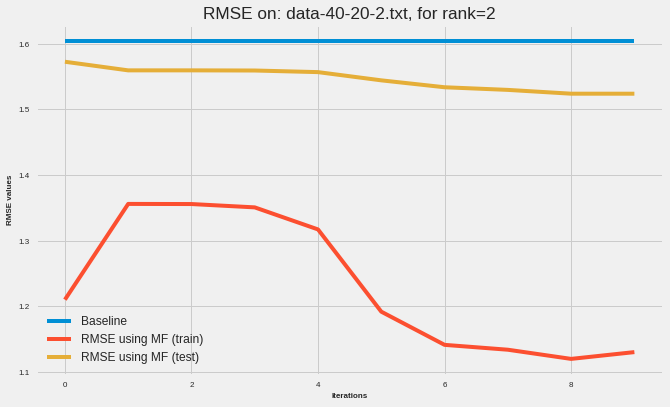

In [0]:
## Test 40-20-2.txt file
run_for_40_20_2_dataset()

**

# 500-500-3 dataset
rank = 1,2,3,5, 10, 20

## rank =3 

2019-02-24 16:34:30,446:training set size: 25000
2019-02-24 16:34:30,446:training set size: 25000
2019-02-24 16:34:30,446:training set size: 25000
2019-02-24 16:34:30,446:training set size: 25000
2019-02-24 16:34:30,453:test set size: 25000
2019-02-24 16:34:30,453:test set size: 25000
2019-02-24 16:34:30,453:test set size: 25000
2019-02-24 16:34:30,453:test set size: 25000


 size of the dataset (50000, 3)
(500, 500)
18 1.8085931611785577
RMSE baseline: (data-500-500-3.txt dataset): 1.8085931611785577
RMSE trainset: (data-500-500-3.txt  dataset): 1.794796990774663
RMSE testset: (data-500-500-3.txt dataset): 1.8020930516221314
Num iterations 18,rmse_prediction_baseline:1.8085931611785577


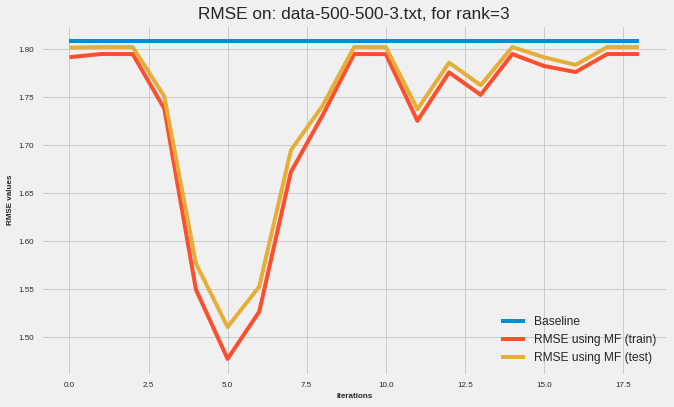

In [0]:
## 500-500-3 - rank = 3
run_for_500_500_3_rank(3)

## rank = 1

2019-02-24 16:37:45,794:training set size: 25000
2019-02-24 16:37:45,794:training set size: 25000
2019-02-24 16:37:45,794:training set size: 25000
2019-02-24 16:37:45,794:training set size: 25000
2019-02-24 16:37:45,804:test set size: 25000
2019-02-24 16:37:45,804:test set size: 25000
2019-02-24 16:37:45,804:test set size: 25000
2019-02-24 16:37:45,804:test set size: 25000


 size of the dataset (50000, 3)
(500, 500)
99 1.8085931611785577
RMSE baseline: (data-500-500-3.txt dataset): 1.8085931611785577
RMSE trainset: (data-500-500-3.txt  dataset): 1.7921375733013951
RMSE testset: (data-500-500-3.txt dataset): 1.7999591835786382
Num iterations 99,rmse_prediction_baseline:1.8085931611785577


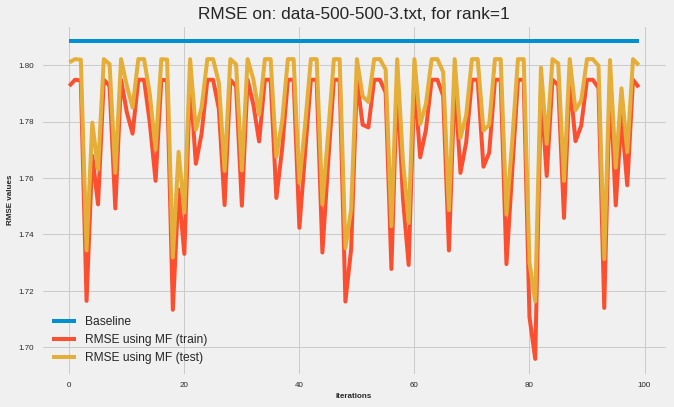

In [0]:
run_for_500_500_3_rank(1)

## rank = 2

2019-02-24 16:49:18,673:training set size: 25000
2019-02-24 16:49:18,673:training set size: 25000
2019-02-24 16:49:18,673:training set size: 25000
2019-02-24 16:49:18,673:training set size: 25000
2019-02-24 16:49:18,686:test set size: 25000
2019-02-24 16:49:18,686:test set size: 25000
2019-02-24 16:49:18,686:test set size: 25000
2019-02-24 16:49:18,686:test set size: 25000


 size of the dataset (50000, 3)
(500, 500)
99 1.8085931611785577
RMSE baseline: (data-500-500-3.txt dataset): 1.8085931611785577
RMSE trainset: (data-500-500-3.txt  dataset): 1.7541833336399946
RMSE testset: (data-500-500-3.txt dataset): 1.7653812667220559
Num iterations 99,rmse_prediction_baseline:1.8085931611785577


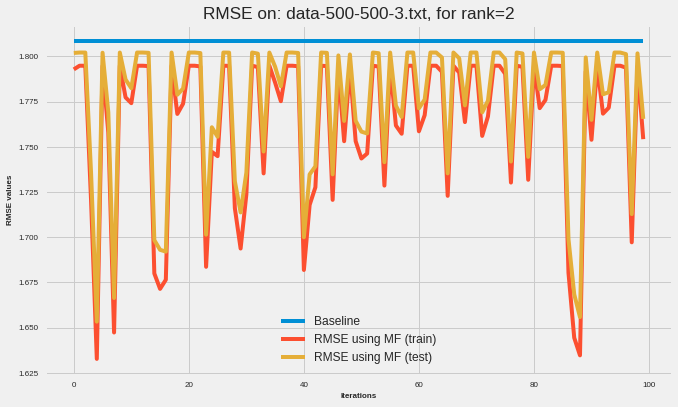

In [0]:
run_for_500_500_3_rank(2)

## rank = 5

2019-02-24 17:50:27,596:training set size: 25000
2019-02-24 17:50:27,596:training set size: 25000
2019-02-24 17:50:27,596:training set size: 25000
2019-02-24 17:50:27,596:training set size: 25000
2019-02-24 17:50:27,609:test set size: 25000
2019-02-24 17:50:27,609:test set size: 25000
2019-02-24 17:50:27,609:test set size: 25000
2019-02-24 17:50:27,609:test set size: 25000


 size of the dataset (50000, 3)
(500, 500)
67 1.8085931611785577
RMSE baseline: (data-500-500-3.txt dataset): 1.8085931611785577
RMSE trainset: (data-500-500-3.txt  dataset): 1.7947969906284449
RMSE testset: (data-500-500-3.txt dataset): 1.8020930515029023
Num iterations 67,rmse_prediction_baseline:1.8085931611785577


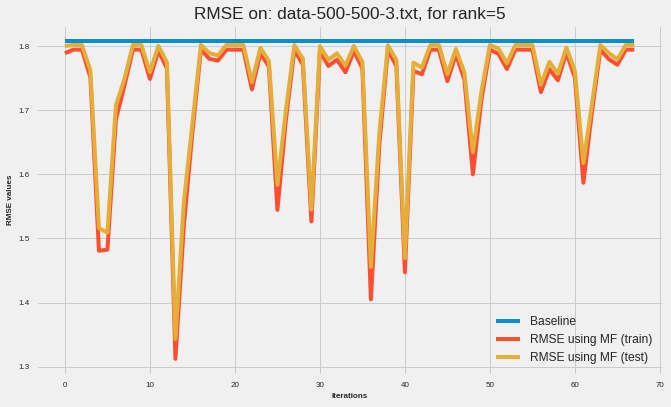

In [0]:
run_for_500_500_3_rank(5)

## rank =10

2019-02-24 18:36:08,923:training set size: 25000
2019-02-24 18:36:08,923:training set size: 25000
2019-02-24 18:36:08,923:training set size: 25000
2019-02-24 18:36:08,923:training set size: 25000
2019-02-24 18:36:08,929:test set size: 25000
2019-02-24 18:36:08,929:test set size: 25000
2019-02-24 18:36:08,929:test set size: 25000
2019-02-24 18:36:08,929:test set size: 25000


 size of the dataset (50000, 3)
(500, 500)
32 1.8085931611785577
RMSE baseline: (data-500-500-3.txt dataset): 1.8085931611785577
RMSE trainset: (data-500-500-3.txt  dataset): 1.7947969888055995
RMSE testset: (data-500-500-3.txt dataset): 1.802093049984137
Num iterations 32,rmse_prediction_baseline:1.8085931611785577


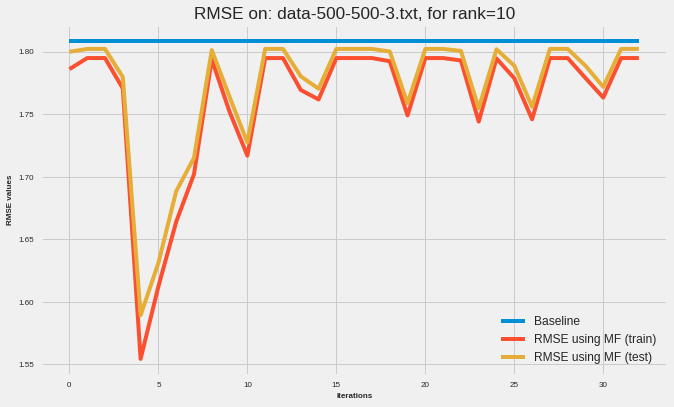

In [0]:
run_for_500_500_3_rank(num_features=10)

## rank = 20

2019-02-24 18:50:43,462:training set size: 25000
2019-02-24 18:50:43,462:training set size: 25000
2019-02-24 18:50:43,462:training set size: 25000
2019-02-24 18:50:43,462:training set size: 25000
2019-02-24 18:50:43,468:test set size: 25000
2019-02-24 18:50:43,468:test set size: 25000
2019-02-24 18:50:43,468:test set size: 25000
2019-02-24 18:50:43,468:test set size: 25000


 size of the dataset (50000, 3)
(500, 500)
99 1.8085931611785577
RMSE baseline: (data-500-500-3.txt dataset): 1.8085931611785577
RMSE trainset: (data-500-500-3.txt  dataset): 1.753938334904978
RMSE testset: (data-500-500-3.txt dataset): 1.7673977363812658
Num iterations 99,rmse_prediction_baseline:1.8085931611785577


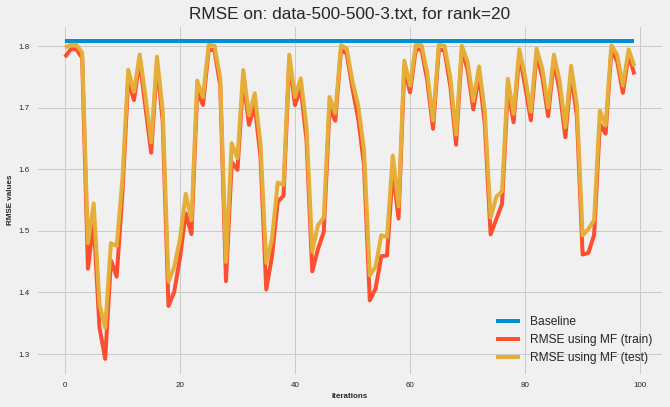

In [0]:
run_for_500_500_3_rank(num_features=20)

## Comparison Plot

2019-02-25 02:05:34,186:training set size: 25000
2019-02-25 02:05:34,188:test set size: 25000


 size of the dataset (50000, 3)
(500, 500)
99 1.8085931611785577
RMSE baseline: (data-500-500-3.txt dataset): 1.8085931611785577
RMSE trainset: (data-500-500-3.txt  dataset): 1.7947796007520807
RMSE testset: (data-500-500-3.txt dataset): 1.802079205095376
Num iterations 99,rmse_prediction_baseline:1.8085931611785577
Completed 1


2019-02-25 02:16:04,749:training set size: 25000
2019-02-25 02:16:04,752:test set size: 25000


 size of the dataset (50000, 3)
(500, 500)
99 1.8085931611785577
RMSE baseline: (data-500-500-3.txt dataset): 1.8085931611785577
RMSE trainset: (data-500-500-3.txt  dataset): 1.7947414696036175
RMSE testset: (data-500-500-3.txt dataset): 1.8020480878415788
Num iterations 99,rmse_prediction_baseline:1.8085931611785577


2019-02-25 02:27:13,448:training set size: 25000
2019-02-25 02:27:13,450:test set size: 25000


 size of the dataset (50000, 3)
(500, 500)
20 1.8085931611785577
RMSE baseline: (data-500-500-3.txt dataset): 1.8085931611785577
RMSE trainset: (data-500-500-3.txt  dataset): 1.7947969907743697
RMSE testset: (data-500-500-3.txt dataset): 1.8020930516220077
Num iterations 20,rmse_prediction_baseline:1.8085931611785577


2019-02-25 02:29:43,806:training set size: 25000
2019-02-25 02:29:43,812:test set size: 25000


 size of the dataset (50000, 3)
(500, 500)
52 1.8085931611785577
RMSE baseline: (data-500-500-3.txt dataset): 1.8085931611785577
RMSE trainset: (data-500-500-3.txt  dataset): 1.7947969907734949
RMSE testset: (data-500-500-3.txt dataset): 1.8020930516214175
Num iterations 52,rmse_prediction_baseline:1.8085931611785577


2019-02-25 02:35:48,369:training set size: 25000
2019-02-25 02:35:48,370:test set size: 25000


 size of the dataset (50000, 3)
(500, 500)
84 1.8085931611785577
RMSE baseline: (data-500-500-3.txt dataset): 1.8085931611785577
RMSE trainset: (data-500-500-3.txt  dataset): 1.7947969905386822
RMSE testset: (data-500-500-3.txt dataset): 1.802093051429972
Num iterations 84,rmse_prediction_baseline:1.8085931611785577


2019-02-25 02:45:29,920:training set size: 25000
2019-02-25 02:45:29,921:test set size: 25000


 size of the dataset (50000, 3)
(500, 500)
99 1.8085931611785577
RMSE baseline: (data-500-500-3.txt dataset): 1.8085931611785577
RMSE trainset: (data-500-500-3.txt  dataset): 1.656553793972044
RMSE testset: (data-500-500-3.txt dataset): 1.6692317206648897
Num iterations 99,rmse_prediction_baseline:1.8085931611785577


TypeError: ignored

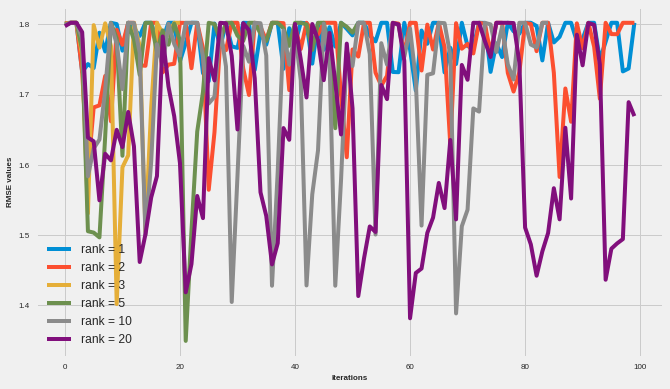

In [0]:
run_for_500_500_ranks()

## Convergence for the algorithm

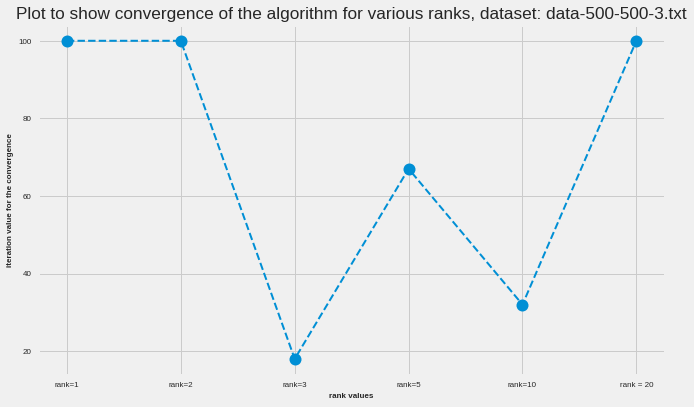

In [0]:
## Convergence
x_values = ["rank=1","rank=2","rank=3","rank=5","rank=10","rank = 20"]
iterations = [100,100,18,67,32,100]

plt.plot(x_values, iterations,  marker='o', linestyle='dashed',
linewidth=2, markersize=12)
plt.xlabel("rank values")
plt.ylabel("iteration value for the convergence")
plt.title("Plot to show convergence of the algorithm for various ranks, dataset: data-500-500-3.txt")
plt.show()


# ml-100k dataset - 
ranks = 5, 20, 100

In [0]:
rank_100k = [5, 20, 100]

  


## rank = 5

2019-02-24 15:26:54,724:training set size: 50000
2019-02-24 15:26:54,724:training set size: 50000
2019-02-24 15:26:54,724:training set size: 50000
2019-02-24 15:26:54,727:test set size: 50000
2019-02-24 15:26:54,727:test set size: 50000
2019-02-24 15:26:54,727:test set size: 50000


 size of the dataset (100000, 3)
(943, 1682)
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Ite

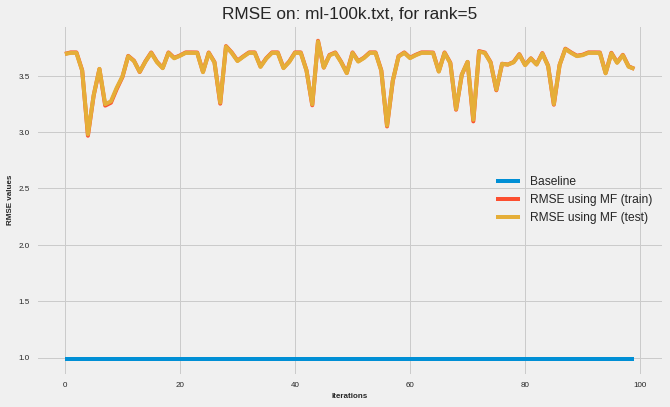

In [0]:
run_for_ml_100k_rank(num_features=5)

## rank = 20

2019-02-24 15:54:41,041:training set size: 50000
2019-02-24 15:54:41,041:training set size: 50000
2019-02-24 15:54:41,041:training set size: 50000
2019-02-24 15:54:41,051:test set size: 50000
2019-02-24 15:54:41,051:test set size: 50000
2019-02-24 15:54:41,051:test set size: 50000


 size of the dataset (100000, 3)
(943, 1682)
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Ite

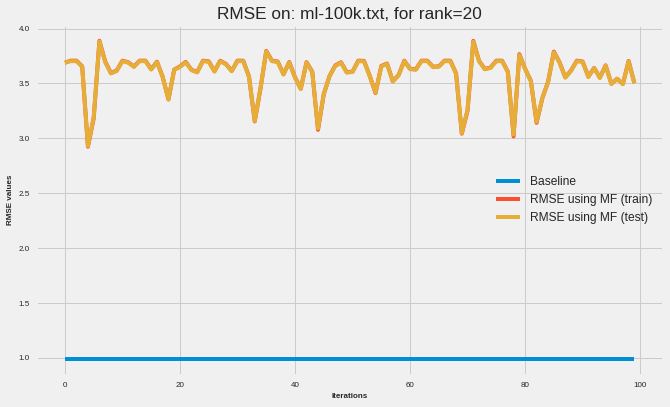

In [0]:
run_for_ml_100k_rank(num_features=20)

## rank = 100

2019-02-24 16:24:18,663:training set size: 50000
2019-02-24 16:24:18,663:training set size: 50000
2019-02-24 16:24:18,663:training set size: 50000
2019-02-24 16:24:18,666:test set size: 50000
2019-02-24 16:24:18,666:test set size: 50000
2019-02-24 16:24:18,666:test set size: 50000


 size of the dataset (100000, 3)
(943, 1682)
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
7 0.9877234995417897
RMSE baseline: (ml-100k.txt dataset): 0.9877234995417897
RMSE trainset: (ml-100k.txt  dataset): 3.7070527374853994
RMSE testset: (ml-100k.txt dataset): 3.7029501750000313
Num iterations 7,rmse_prediction_baseline:0.9877234995417897


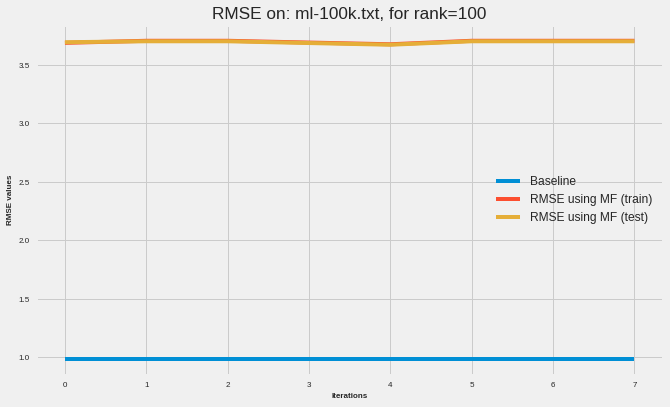

In [0]:
run_for_ml_100k_rank(num_features=100)

## Comparison of the Algorithm

2019-02-25 03:07:29,307:training set size: 50000
2019-02-25 03:07:29,307:training set size: 50000
2019-02-25 03:07:29,307:training set size: 50000
2019-02-25 03:07:29,307:training set size: 50000
2019-02-25 03:07:29,314:test set size: 50000
2019-02-25 03:07:29,314:test set size: 50000
2019-02-25 03:07:29,314:test set size: 50000
2019-02-25 03:07:29,314:test set size: 50000


 size of the dataset (100000, 3)
(943, 1682)
99 0.9877234995417897
RMSE baseline: (ml-100k.txt dataset): 0.9877234995417897
RMSE trainset: (ml-100k.txt  dataset): 3.7070527111127025
RMSE testset: (ml-100k.txt dataset): 3.702950148920062
Num iterations 99,rmse_prediction_baseline:0.9877234995417897
Completed 5


2019-02-25 03:30:45,132:training set size: 50000
2019-02-25 03:30:45,132:training set size: 50000
2019-02-25 03:30:45,132:training set size: 50000
2019-02-25 03:30:45,132:training set size: 50000
2019-02-25 03:30:45,138:test set size: 50000
2019-02-25 03:30:45,138:test set size: 50000
2019-02-25 03:30:45,138:test set size: 50000
2019-02-25 03:30:45,138:test set size: 50000


 size of the dataset (100000, 3)
(943, 1682)
99 0.9877234995417897
RMSE baseline: (ml-100k.txt dataset): 0.9877234995417897
RMSE trainset: (ml-100k.txt  dataset): 3.604856913155617
RMSE testset: (ml-100k.txt dataset): 3.6041737934532283
Num iterations 99,rmse_prediction_baseline:0.9877234995417897
Completed 20


2019-02-25 03:56:28,899:training set size: 50000
2019-02-25 03:56:28,899:training set size: 50000
2019-02-25 03:56:28,899:training set size: 50000
2019-02-25 03:56:28,899:training set size: 50000
2019-02-25 03:56:28,906:test set size: 50000
2019-02-25 03:56:28,906:test set size: 50000
2019-02-25 03:56:28,906:test set size: 50000
2019-02-25 03:56:28,906:test set size: 50000


 size of the dataset (100000, 3)
(943, 1682)
7 0.9877234995417897
RMSE baseline: (ml-100k.txt dataset): 0.9877234995417897
RMSE trainset: (ml-100k.txt  dataset): 3.7070527370155584
RMSE testset: (ml-100k.txt dataset): 3.702950174541485
Num iterations 7,rmse_prediction_baseline:0.9877234995417897
Completed 100


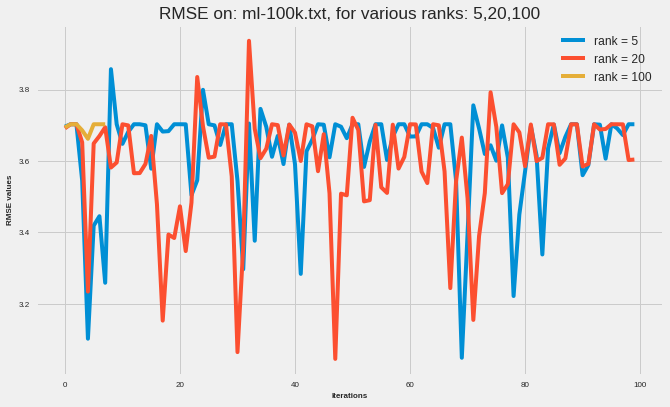

In [0]:
run_for_ml_100k_ranks()

## Convergence of the Algorithm

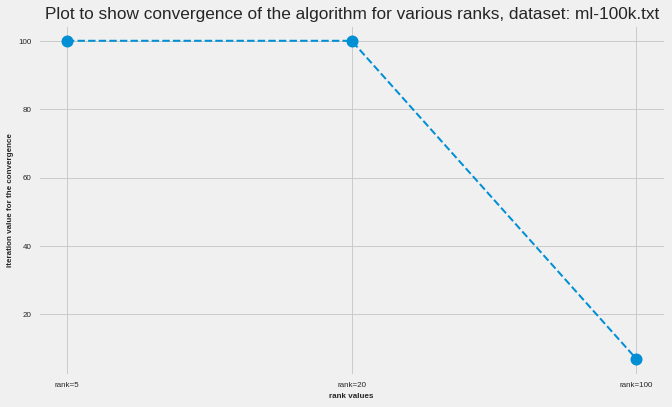

In [0]:
## Convergence
x_values = ["rank=5","rank=20","rank=100"]
iterations = [100,100,7]

plt.plot(x_values, iterations,  marker='o', linestyle='dashed',
linewidth=2, markersize=12)
plt.xlabel("rank values")
plt.ylabel("iteration value for the convergence")
plt.title("Plot to show convergence of the algorithm for various ranks, dataset: ml-100k.txt")
plt.show()